In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import datetime
import os
import sys
import json
import glob

from matplotlib.sankey import Sankey
import plotly.graph_objects as gos
import plotly.io as pio


In [66]:
current_dir = os.path.dirname(os.path.abspath("__file__"))  # Jupyter fallback
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))


# Add 'src' to Python path
sys.path.insert(0, parent_dir)
import main_sim

In [67]:
# Reading output files
# datapath = os.path.join(current_dir, "../..", 'data/outputs/try_DES_data_3runner_new.csv')
datapath = os.path.join(current_dir, "../..", 'data/outputs/DES_data.csv')
df = pd.read_csv(datapath, sep=',', index_col='date')
df.index = pd.to_datetime(df.index)

# Reading pv output

pv_results_dir = os.path.join(current_dir, "../..", 'data/outputs/pv/PVlib_output4ab8bccf.csv')
# pv_file_prefix = 'PVlib_'
# search_pattern = os.path.join(pv_results_dir, f"{pv_file_prefix}*.csv")
# matching_files = glob.glob(search_pattern)
# if matching_files:
#     pv_results_path = matching_files[0]
# pv_results_path =
pv_df = pd.read_csv(pv_results_dir)
pv_df.index = pd.to_datetime(pv_df['Unnamed: 0'])
pv_df.index = pv_df.index.tz_localize(None)

# Reading the demand timeseries used by the sim
input_path = os.path.join(current_dir, "..", '..', 'data','inputs','Input_kfw55_2_el.csv')
input_df = pd.read_csv(input_path, sep=',', skiprows=[0])
input_df.index = pd.to_datetime(input_df['Time'])


In [68]:
# 1. Load the file 
path = os.path.join(current_dir, '..', '..', 'data', 'inputs', 'input_params.json')
with open(path) as f:
    params = json.load(f)

# 2. Load the static params 
params_hp = params.get('hp')
params_ctrl = params.get('ctrl')
params_hwt = params.get('tank')
params_ctrl['tank'] = params['tank'] 


# Instead of init_vals_hwt0 = ..., we grab ALL tanks automatically.
init_vals_tanks = params['init_vals_tank'] 
# Now 'init_vals_tanks' is a dictionary containing ALL tanks found in the file.


# Use .get() so it doesn't crash if they are missing
params_chp = params.get('params_chp')
params_boiler = params.get('params_boiler')

In [69]:
df = df.merge(pv_df, left_index=True, right_index= True, how = 'left')
# 1. CLEAN UP PV DUPLICATES (Fixes _x and _y)
# If we have _x and _y columns, keep _x (usually the main file) and drop _y
cols_to_drop = [c for c in df.columns if c.endswith('_y')]
df.drop(columns=cols_to_drop, inplace=True)

# Rename _x columns back to normal (remove the suffix)
rename_map_pv = {c: c.replace('_x', '') for c in df.columns if c.endswith('_x')}
df.rename(columns=rename_map_pv, inplace=True)
df

,CSV-1.HEATLOAD_0-T_amb,HeatPumpSim-0.HeatPump_0-T_amb,CSV-1.HEATLOAD_0-Heat Demand [kW],HeatPumpSim-0.HeatPump_0-Q_Demand,HeatPumpSim-0.HeatPump_0-Q_Supplied,HeatPumpSim-0.HeatPump_0-heat_source_T,HeatPumpSim-0.HeatPump_0-cons_T,HeatPumpSim-0.HeatPump_0-P_Required,HeatPumpSim-0.HeatPump_0-COP,HeatPumpSim-0.HeatPump_0-cond_m,HeatPumpSim-0.HeatPump_0-cond_in_T,HeatPumpSim-0.HeatPump_0-on_fraction,HeatPumpSim-0.HeatPump_0-Q_evap,ControllerSim-0.Controller_0-heat_demand,ControllerSim-0.Controller_0-heat_supply,ControllerSim-0.Controller_0-generators.hp_demand,ControllerSim-0.Controller_0-generators.hp_supply,ControllerSim-0.Controller_0-generators.chp_demand,ControllerSim-0.Controller_0-generators.chp_supply,ControllerSim-0.Controller_0-sh_supply,ControllerSim-0.Controller_0-dhw_supply,ControllerSim-0.Controller_0-pv_gen,ControllerSim-0.Controller_0-IdealHrodsum,ControllerSim-0.Controller_0-generators.boiler_demand,ControllerSim-0.Controller_0-chp_uptime,ControllerSim-0.Controller_0-req_shTsup,HotWaterTankSim-0.HotWaterTank_0-sensor_00.T,HotWaterTankSim-1.HotWaterTank_0-sensor_00.T,HotWaterTankSim-2.HotWaterTank_0-sensor_00.T,HotWaterTankSim-0.HotWaterTank_0-sensor_01.T,HotWaterTankSim-1.HotWaterTank_0-sensor_01.T,HotWaterTankSim-2.HotWaterTank_0-sensor_01.T,HotWaterTankSim-0.HotWaterTank_0-sensor_02.T,HotWaterTankSim-1.HotWaterTank_0-sensor_02.T,HotWaterTankSim-2.HotWaterTank_0-sensor_02.T,HotWaterTankSim-0.HotWaterTank_0-heat_out.T,HotWaterTankSim-1.HotWaterTank_0-heat_out.T,HotWaterTankSim-2.HotWaterTank_0-heat_out.T,HotWaterTankSim-0.HotWaterTank_0-heat_out.F,HotWaterTankSim-1.HotWaterTank_0-heat_out.F,HotWaterTankSim-2.HotWaterTank_0-heat_out.F,HotWaterTankSim-0.HotWaterTank_0-hp_in.T,HotWaterTankSim-1.HotWaterTank_0-hp_in.T,HotWaterTankSim-2.HotWaterTank_0-hp_in.T,HotWaterTankSim-0.HotWaterTank_0-hp_in.F,HotWaterTankSim-1.HotWaterTank_0-hp_in.F,HotWaterTankSim-2.HotWaterTank_0-hp_in.F,HotWaterTankSim-0.HotWaterTank_0-hp_out.T,HotWaterTankSim-1.HotWaterTank_0-hp_out.T,HotWaterTankSim-2.HotWaterTank_0-hp_out.T,HotWaterTankSim-0.HotWaterTank_0-hp_out.F,HotWaterTankSim-1.HotWaterTank_0-hp_out.F,HotWaterTankSim-2.HotWaterTank_0-hp_out.F,HotWaterTankSim-0.HotWaterTank_0-heat_in.T,HotWaterTankSim-1.HotWaterTank_0-heat_in.T,HotWaterTankSim-2.HotWaterTank_0-heat_in.T,HotWaterTankSim-0.HotWaterTank_0-heat_in.F,HotWaterTankSim-1.HotWaterTank_0-heat_in.F,HotWaterTankSim-2.HotWaterTank_0-heat_in.F,HotWaterTankSim-0.HotWaterTank_0-heat_out2.F,HotWaterTankSim-1.HotWaterTank_0-heat_out2.F,HotWaterTankSim-2.HotWaterTank_0-heat_out2.F,HotWaterTankSim-0.HotWaterTank_0-heat_out2.T,HotWaterTankSim-1.HotWaterTank_0-heat_out2.T,HotWaterTankSim-2.HotWaterTank_0-heat_out2.T,HotWaterTankSim-0.HotWaterTank_0-T_mean,HotWaterTankSim-1.HotWaterTank_0-T_mean,HotWaterTankSim-2.HotWaterTank_0-T_mean,HotWaterTankSim-2.HotWaterTank_0-hr_1.P_th,Chpsim_v2-0.CHP0-P_th,Boilersim_v2-0.Boiler0-P_th,Chpsim_v2-0.CHP0-mdot,Boilersim_v2-0.Boiler0-mdot,Chpsim_v2-0.CHP0-mdot_neg,Chpsim_v2-0.CHP0-temp_in,Chpsim_v2-0.CHP0-Q_demand,Boilersim_v2-0.Boiler0-Q_demand,Chpsim_v2-0.CHP0-temp_out,Boilersim_v2-0.Boiler0-temp_out,Chpsim_v2-0.CHP0-P_el,Chpsim_v2-0.CHP0-uptime,Unnamed: 0,ghi,dni,dhi,temp_air,wind_speed,Power[w]
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,11.5,5.0,51.1900,0.000000e+00,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,51190.0,NaN,0.000000e+00,0.0,0,0.0,41430.0,9760.0,-20.16,0.0,0.0,0.0,37.80,20.252312,18.220420,59.994646,29.999244,29.999244,69.995089,39.994261,39.994261,79.986126,39.994261,39.994261,79.986126,-0.660134,-0.311967,0.000000,39.994261,39.994261,79.986126,0.0,0.000000,0.0,20.252312,0.000000,59.994646,0.000000,0.660134,0.000000,22.800000,18.220420,59.994646,0.660134,0.0,0.000000,0.0,-0.348166,0.000000,39.994261,39.994261,79.986126,30.081939,29.404642,69.991954,0,0.0,0.0,4.0,0.0,-4.0,59.994646,90000.0,0.0,59.994646,75.0,0.0,0.0,2022-01-01 00:00:00,0.0,0.0,253.

# Column translations

In [70]:
# 1. Base dictionary for the unique stuff 
columnname = {
    'Power[w]': 'PV_P[W]', 
    'CSV-0.DNI_0-DNI': 'DNI', 
    'CSV-1.HEATLOAD_0-T_amb':'T_amb', 
    'CSV-1.HEATLOAD_0-Heat Demand [kW]':'Heat Demand [KW]',
    'CHPSim-0.CHP_0-eff_el':'CHP_eff'
}


tank_suffixes = {
    'sensor_00.T': 'sensor0_T',   # Handles the "sensor0" change
    'sensor_01.T': 'sensor1_T',
    'sensor_02.T': 'sensor2_T',
    'heat_out.T':  'heatout_T',   # Handles the "heatout" change
    'heat_out.F':  'heatout_F',
    'heat_out2.T': 'heatout2_T',  # Handles the "heatout2" change
    'heat_out2.F': 'heatout2_F',
    'hp_in.T':     'hp_in_T',     # Keeps the underscore here
    'hp_in.F':     'hp_in_F',
    'hp_out.T':    'hp_out_T',
    'hp_out.F':    'hp_out_F',
    'heat_in.T':   'heatin_T',    # Handles "heatin" change
    'heat_in.F':   'heatin_F',
    'T_mean':      'Tmean',
    'hr_1.P_th':   'hr1_P_th' # Handles heating rods "hr_1" change

}

# 3. The Generic Loop
# Scans all columns. If it sees a Tank, it finds the ID and applies the suffix rule.
for col in df.columns:

    # --- Skip if already renamed ---
    # If it already looks like 'HWTSim0_Tmean' or 'CHP_P_th', skip it.
    if col.startswith('HWT') or col.startswith('CHP_') or col.startswith('Boiler_') or col.startswith('HP_'):
        continue

    # --- TANKS (Generic) ---
    if 'HotWaterTankSim' in col:
        # Example col: 'HotWaterTankSim-0.HotWaterTank_0-heat_out.T'
        
        # A. Get the ID (e.g., '0', '1', '2') automatically
        # Splitting 'HotWaterTankSim-0' to get '0'
        tank_id = col.split('.')[0].split('-')[-1] 

        # B. Apply the correct Suffix Rule
        for ugly_end, clean_end in tank_suffixes.items():
            if col.endswith(ugly_end):
                # Construct the name: HWTSim + 0 + _ + heatout_T
                new_name = f'HWT{tank_id}_{clean_end}'
                columnname[col] = new_name
                break # Stop checking suffixes once we find a match

    # --- HEAT PUMPS ---
    elif 'HeatPump' in col:
        # 'HeatPumpSim-0.HeatPump_0-Q_Demand' -> 'HP_Q_Demand'
        suffix = col.split('-')[-1]
        columnname[col] = f'HP_{suffix}'

    # --- BOILERS  ---
    elif 'Boiler' in col:
        suffix = col.split('-')[-1]
        columnname[col] = f'Boiler_{suffix}'

    # --- CHP  ---
    elif 'CHP' in col and col not in columnname: # Check if not already in dict (eff_el is manual)
        suffix = col.split('-')[-1]
        columnname[col] = f'CHP_{suffix}'

    # --- CONTROLLERS ---
    elif 'Controller' in col:
        suffix = col.split('-')[-1]
        columnname[col] = suffix
        


# 4. Apply Changes
oldcolumns = df.columns
column_translate = np.asarray(list(columnname.keys()))
n = np.setdiff1d(oldcolumns,column_translate) 
print(f'translation not defined for :\n {n}') 

df.rename(columns = columnname, inplace = True)
print(f'{len(df.columns)-len(columnname.keys())} columns were not translated!')

translation not defined for :
 ['Unnamed: 0' 'dhi' 'dni' 'ghi' 'temp_air' 'wind_speed']
4 columns were not translated!


In [71]:
pd.set_option('display.max_columns', None)

C:\Users\Ali\AppData\Local\Temp\ipykernel_22944\1127389962.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



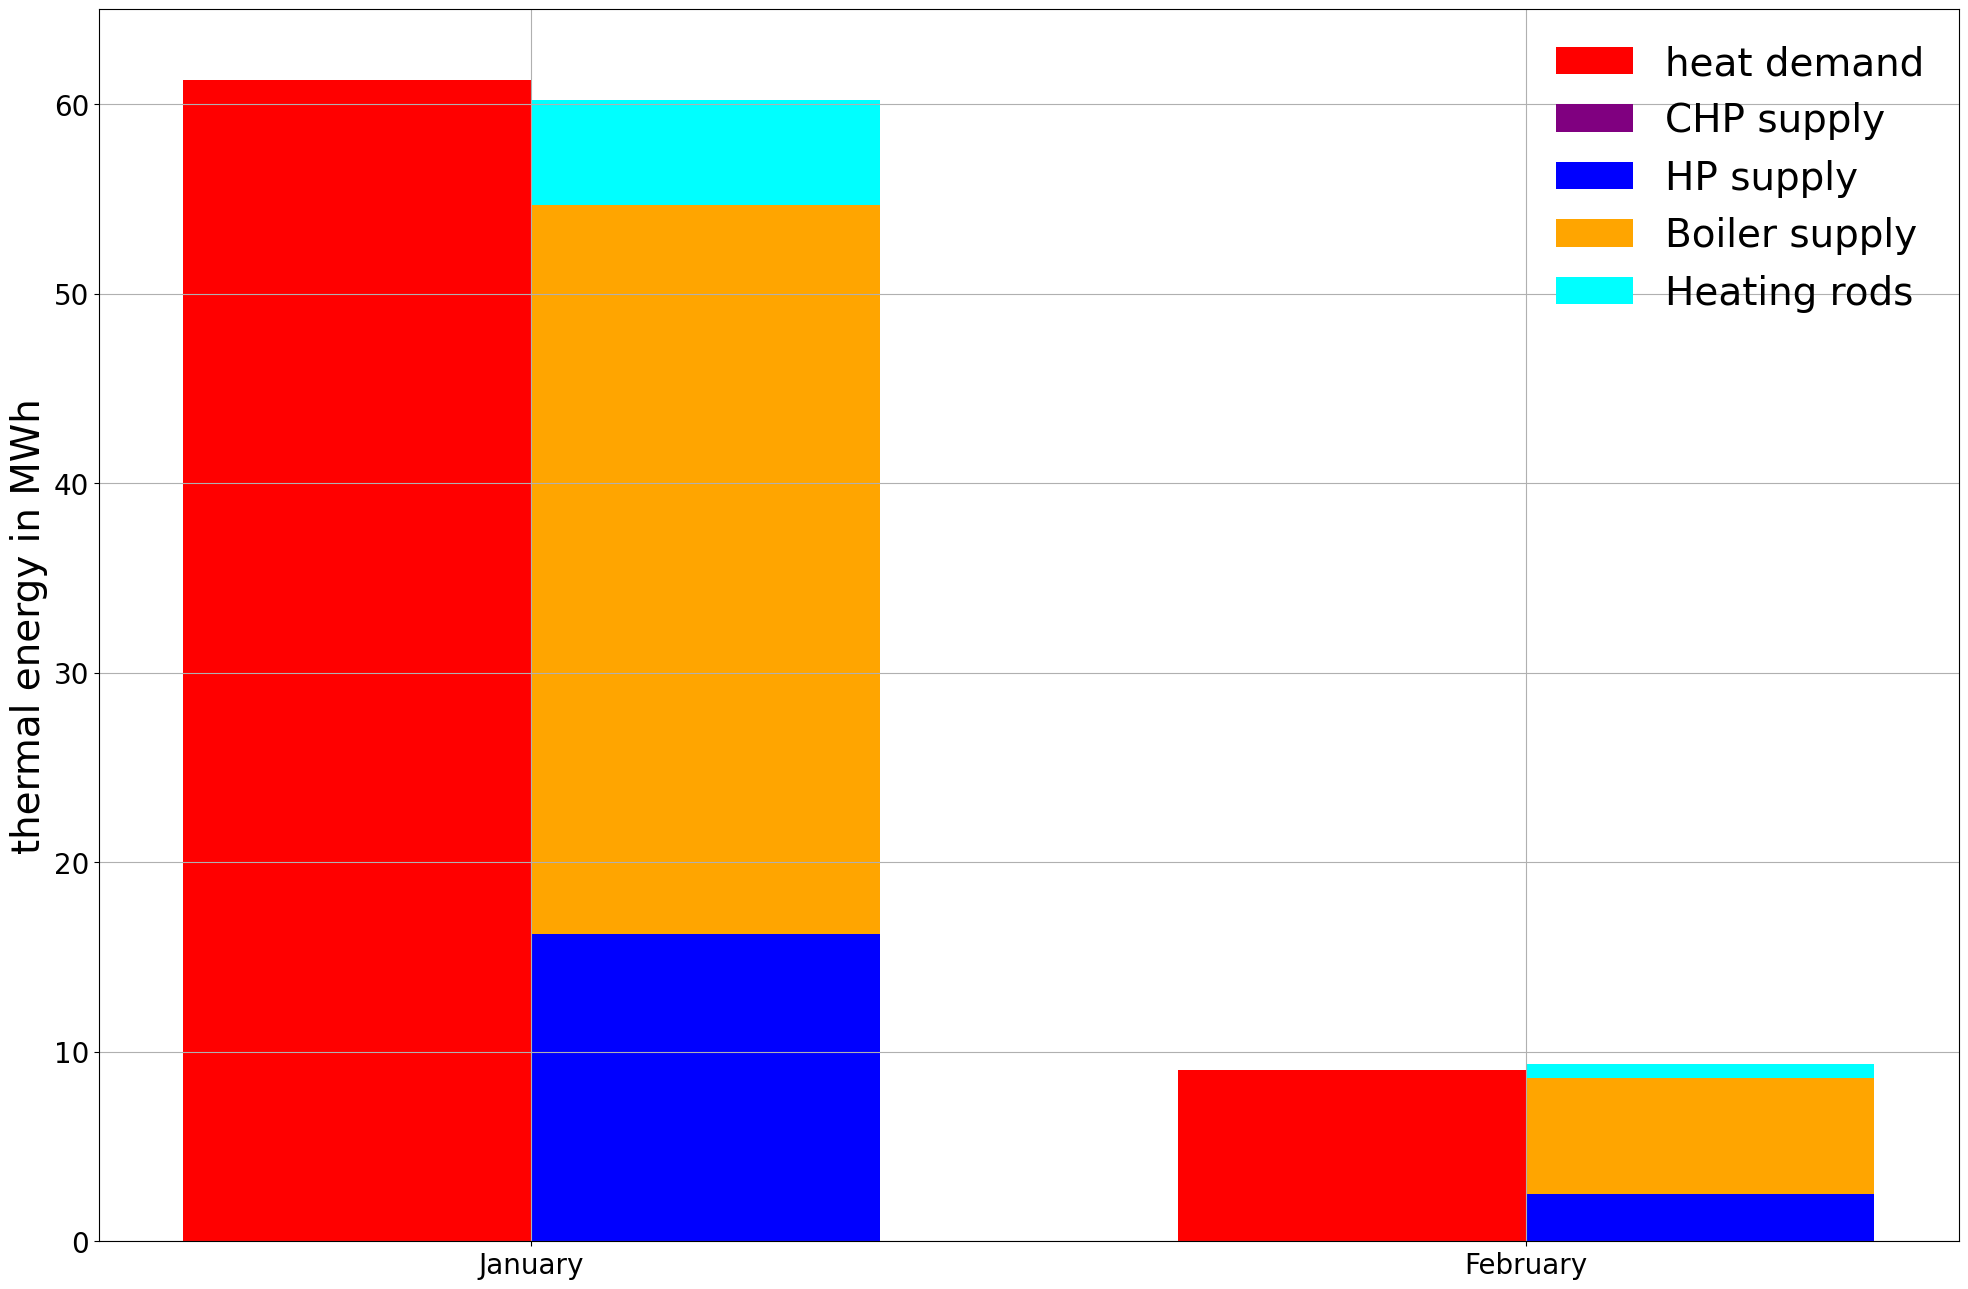

In [72]:
df_monthly = df.resample('M').sum()/4

# Generate the positions for the bars
months = df_monthly.index.month_name()
x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

# Create the figure and the bar plots
plt.figure(figsize=(24, 16))

# Plot heat demand on the left
plt.bar(
    x - width/2, 
    df_monthly['heat_demand']/1_000_000, 
    width=width, 
    color='red', 
    label='heat demand', 
)

# Plot CHP supply stacked with HP supply on the right
plt.bar(
    x + width/2, 
    df_monthly['CHP_P_th']/1_000_000, 
    width=width, 
    color='purple', 
    label='CHP supply', 
)
plt.bar(
    x + width/2, 
    df_monthly['HP_Q_Supplied']/1_000_000,  #TODO replace this with the equivalent direcly from model, as done with chp
    width=width, 
    color='blue', 
    label='HP supply', 
    bottom=df_monthly['CHP_P_th']/1_000_000
)

plt.bar(
    x + width/2, 
    df_monthly['Boiler_P_th']/1_000_000, 
    width=width, 
    color='orange', 
    label='Boiler supply', 
    bottom=(df_monthly['CHP_P_th'] + df_monthly['HP_Q_Supplied'])/1_000_000
)

plt.bar(
    x + width/2, 
    df_monthly['HWT2_hr1_P_th']/1_000_000, 
    width=width, 
    color='cyan', 
    label='Heating rods', 
    bottom=(df_monthly['CHP_P_th'] + df_monthly['HP_Q_Supplied'] + df_monthly['Boiler_P_th'])/1_000_000
)

# Set x-ticks and labels
plt.xticks(x, months, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('thermal energy in MWh', fontsize=28)
plt.ylim(0,65)
plt.grid()

# Set the legend
plt.legend(fontsize=28, frameon=False)

# Display the plot
plt.show()

In [73]:
# Use values from the loaded JSON params (safer than relying on main_sim)
step_size = params_ctrl['step_size'] #todo take from main_sim if possible
volume = params_hwt['volume']
cp_water = 4184 # J/kg*K
ref_temp = params_ctrl['heat_rT']

In [74]:

# Sum (Volume * Cp * (T_avg - T_ref)) for ALL tanks found in JSON
init_temps_sum = 0
num_tanks_init = 0

# Loop through whatever tanks are in the JSON (init_vals_tanks loaded previously)
for tank_name, tank_data in init_vals_tanks.items():
    # tank_data['layers']['T'] gives the list of layer temperatures
    avg_T = np.mean(tank_data['layers']['T'])
    init_temps_sum += avg_T
    num_tanks_init += 1

# Calculate Total Initial Energy (Wh)
init_energy = (volume * cp_water * (init_temps_sum - (num_tanks_init * ref_temp))) / 3600 

In [75]:

# Find all columns like 'HWTSim0_Tmean', 'HWTSim1_Tmean' etc.
tmean_cols = [c for c in df.columns if c.endswith('_Tmean')]

# Sum the LAST value (iloc[-1]) of all these columns
final_temps_sum = df[tmean_cols].iloc[-1].sum()

# Calculate Total Final Energy (Wh)
end_energy = (volume * cp_water * (final_temps_sum - (len(tmean_cols) * ref_temp))) / 3600   

In [85]:
# Helper function 
def get_energy(col_series):
    # Sums power (Watts) * time (hours) = Energy (Wh)
    return col_series.sum() * step_size / 3600 

# Dictionary to store results. 
# Default is 0. If component exists, we overwrite it.
energies = {
    'chp_supply': 0, 'chp_el_supply': 0,
    'boiler_supply': 0,
    'hp_req': 0, 'hp_evap': 0, 'hp_supply': 0,
    'pv_supply': 0,
    'hrods_supply': 0,
    'sh_supply': 0, 'dhw_supply': 0, # 3 and 4 runners columns
    'heat_supply': 0, # 2 runner column 
    'ideal_supply': 0
}

# A. CHP (Look for ANY column starting with CHP_ and ending with P_th)
chp_th_cols = [c for c in df.columns if c.startswith('CHP_') and c.endswith('P_th')]
if chp_th_cols:
    energies['chp_supply'] = get_energy(df[chp_th_cols[0]]) # Assumes 1 main CHP

chp_el_cols = [c for c in df.columns if c.startswith('CHP_') and 'P_el' in c] # Usually P_el or eff_el
if chp_el_cols:
     energies['chp_el_supply'] = get_energy(df[chp_el_cols[0]])

# B. Boiler
boiler_cols = [c for c in df.columns if c.startswith('Boiler_') and c.endswith('P_th')]
if boiler_cols:
    energies['boiler_supply'] = get_energy(df[boiler_cols[0]])

# C. Heat Pump
if 'HP_P_Required' in df.columns: energies['hp_req'] = get_energy(df['HP_P_Required'])
if 'HP_Q_Evap' in df.columns:     energies['hp_evap'] = get_energy(df['HP_Q_Evap'])
if 'HP_Q_Supplied' in df.columns: energies['hp_supply'] = get_energy(df['HP_Q_Supplied'])

# D. Heating Rods (Generic Sum of ALL rods found)
# Finds HWTSim2_hr1_P_th, HWTSim0_hr1_P_th, etc.
rod_cols = [c for c in df.columns if 'hr1_P_th' in c]
if rod_cols:
    # Sum all rods together (axis=1 sums across columns if multiple exist)
    total_rod_power = df[rod_cols].sum(axis=1) 
    energies['hrods_supply'] = get_energy(total_rod_power)

# E. Loads & PV (Using the mapped names)
if 'PV_P[W]' in df.columns: energies['pv_supply'] = get_energy(df['PV_P[W]'])

# Check for 3/4-Runner (Separate)
if 'sh_supply' in df.columns: 
    energies['sh_supply'] = get_energy(df['sh_supply'])
if 'dhw_supply' in df.columns: 
    energies['dhw_supply'] = get_energy(df['dhw_supply'])

# Check for 2-Runner (Combined)
# We check both just to be safe.
if 'heat_supply' in df.columns:
    energies['heat_supply'] = get_energy(df['heat_supply'])

if 'heat_demand' in df.columns:
    energies['heat_demand'] = get_energy(df['heat_demand'])


# --- IDEAL HEATER SEARCH ---
# The old code used 'IdealHrodsum'. We look for it specifically.
if 'IdealHrodsum' in df.columns:
    energies['ideal_supply'] = get_energy(df['IdealHrodsum'])

#checke for differences in heat supply vs demand for 2-runner cases
if energies['heat_demand'] !=0:
    diff_heat = energies['heat_supply'] - energies['heat_demand']
    print(f'Difference between heat supply and demand: {diff_heat} Wh')

Difference between heat supply and demand: -70291677.5 Wh


In [77]:
# Total Heat entering the buffer
energies['total_supply'] = (energies['chp_supply'] + 
                            energies['boiler_supply'] + 
                            energies['hp_supply'] + 
                            energies['hrods_supply'])

print("Energy Calculation Complete.")
print(f"Init Energy: {init_energy:.2f} MWh")
print(f"End Energy:  {end_energy:.2f} MWh")
print(f"CHP Supply:  {energies['chp_supply']:.2f} MWh")

Energy Calculation Complete.
Init Energy: 581111.11 MWh
End Energy:  433213.36 MWh
CHP Supply:  0.00 MWh


In [78]:
# --- 1. PREPARE DATA ---
clone_df = df.copy(deep=True)

# --- 2. GENERIC PRODUCERS ---
# We look for columns we know represent electricity generation
producers = {}

# Check for PV
if 'PV_P[W]' in clone_df.columns:
    producers['PV'] = clone_df['PV_P[W]']

# Check for CHP (Dynamic: finds CHP_P_el or CHP_eff_el)
# We look for any column starting with 'CHP_' and containing 'P_el'
chp_el_col = [c for c in clone_df.columns if c.startswith('CHP_') and 'P_el' in c]
if chp_el_col:
    producers['BHKW'] = clone_df[chp_el_col[0]]

# --- 3. GENERIC USERS (CONSUMERS) ---
users = {}

# Household Demand (Standard name from renaming step)
if 'Household_demand' in clone_df.columns: # Or 'Electricity Demand [W]'
     users['Haushaltstrom'] = clone_df['Household_demand']
elif 'Electricity Demand [W]' in input_df.columns:
     users['Haushaltstrom'] = input_df['Electricity Demand [W]']

# Heat Pump Electric Requirement
if 'HP_P_Required' in clone_df.columns:
    users['Wärmepumpe'] = clone_df['HP_P_Required']

# Heating Rods (The electrical consumption side)
# We grab the same columns we found in the thermal step
rod_cols = [c for c in clone_df.columns if 'hr1_P_th' in c]
if rod_cols:
    # Sum them up and divide by efficiency (assumed 0.98 as per old code)
    # This handles 1 rod or 3 rods automatically.
    users['Heizstäbe'] = clone_df[rod_cols].sum(axis=1) / 0.98

# --- 4. CREATE LINKS (The same logic as before) ---
users_keys = list(users.keys())
producers_keys = list(producers.keys())
elec_links_df = pd.DataFrame({}, index=clone_df.index) # Initialize with matching index

print(f"Detected Electrical Producers: {producers_keys}")
print(f"Detected Electrical Users: {users_keys}")

Detected Electrical Producers: ['PV', 'BHKW']
Detected Electrical Users: ['Haushaltstrom', 'Wärmepumpe', 'Heizstäbe']


In [79]:
import numpy as np

# Create copies so we don't mess up the original data
remaining_supply = {k: v.copy() for k, v in producers.items()}
remaining_demand = {k: v.copy() for k, v in users.items()}

# Prepare the DataFrame to store results
elec_links_df = pd.DataFrame(index=clone_df.index)

# Instead of looping through rows (35,000+), we loop through Components (only ~3-4)
# This preserves the priority order: First User in list gets power first.
for u_key in users_keys:
    for p_key in producers_keys:
        
        # Calculate flow for the WHOLE YEAR at once
        # Flow is the minimum of what the User needs vs what the Producer has left
        flow = np.minimum(remaining_demand[u_key], remaining_supply[p_key])
        
        # Save the result
        col_name = f'{p_key}:{u_key}'
        elec_links_df[col_name] = flow
        
        # Update the remainders
        remaining_demand[u_key] -= flow
        remaining_supply[p_key] -= flow

# HANDLE THE GRID (NETZ)
# If a User still has demand > 0, they buy from Grid
for u_key in users_keys:
    import_needed = remaining_demand[u_key]
    # Only save if there is actual import (avoid clogging table with 0s)
    if import_needed.sum() > 0:
        elec_links_df[f'Netz:{u_key}'] = import_needed

# If a Producer still has supply > 0, they sell to Grid
for p_key in producers_keys:
    export_possible = remaining_supply[p_key]
    if export_possible.sum() > 0:
        elec_links_df[f'{p_key}:Stromerzeugung'] = export_possible


# Create the final dictionary for the plot
# 1. Calculate the Totals (This creates the 9 connections including zeros)
raw_links = {k: [elec_links_df[k].sum() * step_size/3600 , 'springgreen'] for k in elec_links_df.columns}

# 2. THE FILTER: Keep only non-zero connections
# "If the value (v[0]) is greater than 0, keep it. Otherwise, drop it."
elec_links = {k: v for k, v in raw_links.items() if v[0] > 0}

print(f"Original Connections: {len(raw_links)}")
print(f"Filtered Connections: {len(elec_links)}")
print("Active Links:", list(elec_links.keys()))
elec_links

Original Connections: 9
Filtered Connections: 4
Active Links: ['PV:Haushaltstrom', 'Netz:Haushaltstrom', 'Netz:Wärmepumpe', 'Netz:Heizstäbe']


{'PV:Haushaltstrom': [7908902.747119626, 'springgreen'],
 'Netz:Haushaltstrom': [56449172.00288038, 'springgreen'],
 'Netz:Wärmepumpe': [5245592.2111550765, 'springgreen'],
 'Netz:Heizstäbe': [6387755.102040816, 'springgreen']}

In [80]:
elec_links_df

,PV:Haushaltstrom,BHKW:Haushaltstrom,PV:Wärmepumpe,BHKW:Wärmepumpe,PV:Heizstäbe,BHKW:Heizstäbe,Netz:Haushaltstrom,Netz:Wärmepumpe,Netz:Heizstäbe
date,,,,,,,,,
2022-01-01 00:00:00,-20.16,0.0,0.0,0.0,0.0,0.0,49378.16,0.000000,0.0
2022-01-01 00:15:00,-20.16,0.0,0.0,0.0,0.0,0.0,51063.16,0.000000,0.0
2022-01-01 00:30:00,-20.16,0.0,0.0,0.0,0.0,0.0,51248.16,8654.465192,0.0
2022-01-01 00:45:00,-20.16,0.0,0.0,0.0,0.0,0.0,52651.16,8538.897914,0.0
2022-01-01 01:00:00,-20.16,0.0,0.0,0.0,0.0,0.0,45595.16,8882.217477,0.0
...,...,...,...,...,...,...,...,...,...
2022-02-04 22:45:00,-20.16,0.0,0.0,0.0,0.0,0.0,79618.16,0.000000,0.0
2022-02-04 23:00:00,-20.16,0.0,0.0,0.0,0.0,0.0,63009.16,0.000000,0.0
2022-02-04 23:15:00,-20.16,0.0,0.0,0.0,0.0,0.0,63718.16,0.000000,0.0


In [81]:
# --- 1. SETUP COLORS (You can move this to a config file later) ---
color_map = {
    'BHKW': 'rgba(255, 49, 20, 0.7)',       # Red-ish
    'Gaskessel': 'rgba(255, 0, 0, 0.7)',    # Red
    'Wärmepumpe': 'rgba(255, 0, 75, 0.7)',  # Pink-ish
    'Umwelt': 'rgba(0, 180, 138, 0.7)',     # Green-ish (Source for HP)
    'Heizstäbe': 'rgba(255, 197, 41, 0.7)', # Yellow/Orange
    'IdealHeater': 'crimson',
    'TWW': 'rgba(109, 0, 250, 0.7)',        # Purple (DHW)
    'RH': 'rgba(109, 0, 250, 0.7)',         # Purple (Space Heat)
    'Verlust': 'rgba(130, 0, 3, 0.56)'      # Dark Red (Loss)
}

# --- INITIALIZE LISTS ---
thermal_links = {}

# --- INPUTS (Producers -> Buffer) ---
# We check the 'energies' dict we calculated in the Math Block

# CHP
if energies.get('chp_supply', 0) > 0:
    thermal_links['BHKW:Pufferspeicher'] = [energies['chp_supply'], color_map['BHKW']]

# Boiler
if energies.get('boiler_supply', 0) > 0:
    thermal_links['Gaskessel:Pufferspeicher'] = [energies['boiler_supply'], color_map['Gaskessel']]

# Heat Pump (Requires two steps: Environment -> HP -> Buffer)
if energies.get('hp_supply', 0) > 0:
    # 1. Environment to HP (Evaporation energy)
    thermal_links['Umwelt:Wärmepumpe'] = [energies['hp_evap'], color_map['Umwelt']]
    # 2. HP to Buffer (Total Supply)
    thermal_links['Wärmepumpe:Pufferspeicher'] = [energies['hp_supply'], color_map['Wärmepumpe']]

# Heating Rods (Generic: Works for 1 or 3 rods)
if energies.get('hrods_supply', 0) > 0:
    thermal_links['Heizstäbe:Pufferspeicher'] = [energies['hrods_supply'], color_map['Heizstäbe']]

if energies.get('ideal_supply', 0) > 0:
    thermal_links['IdealHeater:Pufferspeicher'] = [energies['ideal_supply'], color_map['IdealHeater']]


# --- OUTPUTS (Buffer -> Consumers) ---

# DHW (Domestic Hot Water)
if energies.get('dhw_supply', 0) > 0:
    thermal_links['Pufferspeicher:TWW'] = [energies['dhw_supply'], color_map['TWW']]

# Space Heating (RH)
if energies.get('sh_supply', 0) > 0:
    thermal_links['Pufferspeicher:RH'] = [energies['sh_supply'], color_map['RH']]


# --- THE GENERIC LOSS CALCULATION ---
# Loss = (Inputs + Init_Storage) - (Outputs + Final_Storage)

# A. Sum all Inputs (Generic sum of whatever exists in the links so far)
total_input_energy = 0
for key, val in thermal_links.items():
    if key.endswith(':Pufferspeicher'): # Only sum things entering the buffer
        total_input_energy += val[0]

# Add Initial Storage Energy (calculated in Math block)
total_input_energy += init_energy

# B. Sum all Outputs
total_output_energy = 0
for key, val in thermal_links.items():
    if key.startswith('Pufferspeicher:'): # Only sum things leaving the buffer
        total_output_energy += val[0]

# Add Final Storage Energy
total_output_energy += end_energy

# C. Calculate Difference
energy_loss = total_input_energy - total_output_energy

# D. Create the Loss Link
if energy_loss > 0:
    thermal_links['Pufferspeicher:Energieverlust'] = [energy_loss, color_map['Verlust']]
else:
    print(f"Warning: Calculated negative loss ({energy_loss}). Check sensors.")


# --- MERGE EVERYTHING ---
# Combine your Electrical Links (Green) with these new Thermal Links (Red/Blue)
final_links = {**elec_links, **thermal_links}

print(f"Generated {len(final_links)} Sankey Connections.")
final_links

Generated 12 Sankey Connections.


{'PV:Haushaltstrom': [7908902.747119626, 'springgreen'],
 'Netz:Haushaltstrom': [56449172.00288038, 'springgreen'],
 'Netz:Wärmepumpe': [5245592.2111550765, 'springgreen'],
 'Netz:Heizstäbe': [6387755.102040816, 'springgreen'],
 'Gaskessel:Pufferspeicher': [44550000.0, 'rgba(255, 0, 0, 0.7)'],
 'Umwelt:Wärmepumpe': [0, 'rgba(0, 180, 138, 0.7)'],
 'Wärmepumpe:Pufferspeicher': [18716375.0, 'rgba(255, 0, 75, 0.7)'],
 'Heizstäbe:Pufferspeicher': [6260000.0, 'rgba(255, 197, 41, 0.7)'],
 'IdealHeater:Pufferspeicher': [700775.195309063, 'crimson'],
 'Pufferspeicher:TWW': [18477365.0, 'rgba(109, 0, 250, 0.7)'],
 'Pufferspeicher:RH': [51814312.5, 'rgba(109, 0, 250, 0.7)'],
 'Pufferspeicher:Energieverlust': [83370.44592368603, 'rgba(130, 0, 3, 0.56)']}

In [82]:
import plotly.graph_objects as go

# --- 1. EXTRACT UNIQUE NODES ---
# We look at every connection in 'final_links' (e.g., 'PV:Haushaltstrom')
# and split them to find every unique participant.
unique_nodes = set()

for link_name in final_links.keys():
    source, target = link_name.split(':')
    unique_nodes.add(source)
    unique_nodes.add(target)

# Convert to a sorted list (so the order is fixed)
node_labels = sorted(list(unique_nodes))
print(f"Nodes found: {node_labels}")


# --- 2. ASSIGN COLORS GENERICALLY ---
# We try to use your preferred colors. If a node is new (unknown), we give it a default color.
preferred_colors = {
    'Netz': 'gold',
    'Haushaltstrom': 'yellow',
    'Wärmepumpe': 'rgba(217, 104, 0, 1)', # Orange-ish
    'Pufferspeicher': 'rgba(0, 0, 189, 0.8)', # Blue
    'Wärmelast': 'green',
    'BHKW': 'brown',
    'Stromerzeugung': 'rgba(0, 168, 0, 0.5)',
    'Pufferspeicher:Energieverlust': 'rgba(69, 0, 0, 0.76)',
    'Umwelt': 'rgba(0, 200, 150, 0.8)',
    'Gaskessel': 'red',
    'Heizstäbe': 'magenta',
    'TWW': 'teal',
    'RH': 'thistle',
    'PV': 'yellowgreen',
    'IdealHeater' : 'crimson',
    'Energieverlust': 'rgba(69, 0, 0, 0.76)'
}

# Build the color list in the exact order of 'node_labels'
node_colors = []
for node in node_labels:
    # .get() returns the specific color if found, or 'grey' if not found
    color = preferred_colors.get(node, 'lightgrey') 
    node_colors.append(color)


# --- 3. MAP LINKS TO INDICES ---
# Plotly needs numbers (0, 1, 2), not names. We look up the index of each name.
source_indices = []
target_indices = []
link_values = []
link_colors = []

for link_name, link_data in final_links.items():
    src_name, tgt_name = link_name.split(':')
    
    # Find the ID number (0, 1, 2...) for these names
    source_indices.append(node_labels.index(src_name))
    target_indices.append(node_labels.index(tgt_name))
    
    # Get the value (width) and color
    link_values.append(link_data[0])
    link_colors.append(link_data[1])


# --- 4. DRAW THE PLOT ---
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valueformat = ".3s",
    valuesuffix = "Wh",
    
    # Define the Boxes (Nodes)
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_labels,
      color = node_colors
    ),
    
    # Define the Arrows (Links)
    link = dict(
      source = source_indices,
      target = target_indices,
      value = link_values,
      color = link_colors
    )
)])

fig.update_layout(title_text="Generic Energy Balance Sankey", font_size=14)
fig.show()

# Optional: Save
# if print_plot:
#      fig.write_html('generic_sankey.html')

Nodes found: ['Energieverlust', 'Gaskessel', 'Haushaltstrom', 'Heizstäbe', 'IdealHeater', 'Netz', 'PV', 'Pufferspeicher', 'RH', 'TWW', 'Umwelt', 'Wärmepumpe']


In [83]:
import plotly.graph_objects as go

# --- 1. EXTRACT UNIQUE NODES ---
# We look at every connection in 'final_links' (e.g., 'PV:Haushaltstrom')
# and split them to find every unique participant.
unique_nodes = set()

for link_name in elec_links.keys():
    source, target = link_name.split(':')
    unique_nodes.add(source)
    unique_nodes.add(target)

# Convert to a sorted list (so the order is fixed)
node_labels = sorted(list(unique_nodes))
print(f"Nodes found: {node_labels}")


# Build the color list in the exact order of 'node_labels'
node_colors = []
for node in node_labels:
    # .get() returns the specific color if found, or 'grey' if not found
    color = preferred_colors.get(node, 'lightgrey') 
    node_colors.append(color)


# --- 3. MAP LINKS TO INDICES ---
# Plotly needs numbers (0, 1, 2), not names. We look up the index of each name.
source_indices = []
target_indices = []
link_values = []
link_colors = []

for link_name, link_data in elec_links.items():
    src_name, tgt_name = link_name.split(':')
    
    # Find the ID number (0, 1, 2...) for these names
    source_indices.append(node_labels.index(src_name))
    target_indices.append(node_labels.index(tgt_name))
    
    # Get the value (width) and color
    link_values.append(link_data[0])
    link_colors.append(link_data[1])


# --- 4. DRAW THE PLOT ---
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valueformat = ".3s",
    valuesuffix = "Wh",
    
    # Define the Boxes (Nodes)
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_labels,
      color = node_colors
    ),
    
    # Define the Arrows (Links)
    link = dict(
      source = source_indices,
      target = target_indices,
      value = link_values,
      color = link_colors
    )
)])

fig.update_layout(title_text="Generic Energy Balance Sankey", font_size=14)
fig.show()

# Optional: Save
# if print_plot:
#      fig.write_html('generic_sankey.html')

Nodes found: ['Haushaltstrom', 'Heizstäbe', 'Netz', 'PV', 'Wärmepumpe']


In [84]:

fig = go.Figure()

# ----------------------------------------------------------------Power plots---------------------------------------------
fig.add_trace(go.Scatter(
    y=df['HP_Q_Supplied'],
    x = df.index,
    mode='lines',
    name='Wärmepumpe',
    line=dict(color='blue', shape="hv")
))

# Second plot (Boiler Simulation)
fig.add_trace(go.Scatter(
    y=df['CHP_P_th'],
    x = df.index,
    mode='lines',
    name='BHKW',
    line=dict(color='red', shape="hv"),
    # yaxis='y2'  # Associate it with a second subplot
))

fig.add_trace(go.Scatter(
    y=df['Boiler_P_th'],
    x = df.index,
    mode='lines',
    name='Gaskessel',
    line=dict(color='sienna', shape="hv"),
    # yaxis='y2'  # Associate it with a second subplot
))

fig.add_trace(go.Scatter(
    # y=df['Heating rods total'], # controller heating rod, might delete later
    y=df['HWT2_hr1_P_th'],
    x = df.index,
    mode='lines',
    name='Heizstäbe',
    line=dict(color='yellow', shape="hv"),
    # yaxis='y2'  # Associate it with a second subplot
))
#----------------------------------------------------------------Temp plots-----------------------------------------------------------


fig.add_trace(go.Scatter(
    y=df['HWT2_sensor0_T'],
    x = df.index,
    mode='lines',
    name='Tank[2]_bottom_temp',
    line=dict(color='cyan', shape="hv"),
    yaxis='y2'  
))

fig.add_trace(go.Scatter(
    y=df['HWT2_sensor2_T'],
    x = df.index,
    mode='lines',
    name='Tank[2]_Top_temp',
    line=dict(color='sandybrown', shape="hv"),
    yaxis='y2'  
))

fig.add_trace(go.Scatter(
    y=df['HWT1_sensor2_T'],
    x = df.index,
    mode='lines',
    name='Tank[1]_Top_temp',
    line=dict(color='thistle', shape="hv"),
    yaxis='y2'  
))

fig.add_trace(go.Scatter(
    x=[df.index.min(), df.index.max()],  
    y=[65, 65],  # Constant y-value
    mode="lines",
    name="T_sp_h",
    line=dict(color="grey", dash="dash"),
    yaxis="y2"  
))

#---------------------------------------------------------------Heat Demand in KW-----------------------------------------------------

fig.add_trace(go.Scatter(
    y=df['Heat Demand [KW]']*1000,
    x = df.index,
    mode='lines',
    name='Wärmelast',
    line=dict(color='springgreen', shape="hv"),
    yaxis='y1'  
))


# --------------------------------------------------------------Chp uptime plots -------------------------------------
# fig.add_trace(go.Scatter(
#     y=df['CHPSim-0.CHP_0-chp_uptime'],
#     x = df.index,
#     mode='lines',
#     name='chp uptime',
#     line=dict(color='cyan', shape="hv"),
#     yaxis='y3'  # Associate it with a second subplot
# ))

# fig.add_trace(go.Scatter(
#     y=df['CHPSim-0.CHP_0-chp_uptime'],
#     x = df.index,
#     mode='lines',
#     name='chp uptime from controller',
#     line=dict(color='lime', shape="hv"),
#     yaxis='y3'  # Associate it with a second subplot
# ))
#------------------------------------------------------------------------------------------------------

fig.update_layout(
    height=600,  # Total height of the figure
    showlegend=True,
    xaxis=dict(title='Time'),
    yaxis=dict(title='Power in W'),
    yaxis2=dict(
        title='Temperature',
        overlaying='y',  # Overlay y-axis for second subplot
        side='right',
        anchor='free',
        position=1
    ),
    yaxis3 = dict(title='uptime in minutes',
        overlaying='y',  # Overlay y-axis for second subplot
        side='right',
        anchor='free',
        position=1)
)